In [18]:
!pip install Optuna

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
SEED = 1234

In [20]:
# Cargar el conjunto de datos
datos = pd.read_csv("Temp_Asu20092021.csv")

In [21]:
# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

#PRIMER APORTE EN EL CODIGO
# Interpolar valores faltantes y reindexar para tener frecuencia horaria
datos = datos.resample('H').interpolate()

In [22]:
# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

In [23]:
# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5)])
percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5']

In [24]:
# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)

In [25]:
# Crear otras variables
#diferencias entre temperaturas horarias
datos['Temp_diff'] = datos['Temperatura'].diff()
#media móvil
datos['Temp_rolling_mean'] = datos['Temperatura'].rolling(window=24).mean()
#desviación estándar móvil
datos['Temp_rolling_std'] = datos['Temperatura'].rolling(window=24).std()

In [26]:
# Eliminar filas con valores faltantes
datos.dropna(inplace=True)
percentiles_diarios.dropna(inplace=True)

In [27]:
# Características originales del código base: percentiles 95, mediana y 5
X_original = percentiles_diarios[['Percentil_95', 'Mediana', 'Percentil_5']]

# Características adicionales: diferencia de temperatura, media móvil y desviación estándar móvil
X_nuevas = datos[['Temp_diff', 'Temp_rolling_mean', 'Temp_rolling_std']].resample('D').mean()

# Seleccionar características
X = pd.concat([X_original, X_nuevas], axis=1)
X = X.iloc[:-1]
#X= percentiles_diarios[['Percentil_95', 'Mediana', 'Percentil_5']]
y = percentiles_diarios[['Percentil_95_siguiente_dia','Mediana_siguiente_dia','Percentil_5_siguiente_dia']].values

In [28]:
# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)

In [29]:
# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)

In [30]:
# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = trial.suggest_int('num_capas', 1, 3)
    #tf.keras.utils.set_random_seed(SEED)~
    tasa_aprendizaje = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64, 128])

    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['mae'])  # Mean Absolute Error (MAE) para evaluación

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=30, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

In [31]:
# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=15) # Aumentar a 100 trials sería lo ideal pero toma demasiado tiempo

[I 2024-09-14 22:25:52,646] A new study created in memory with name: no-name-4cc7be35-1e23-47a8-a322-c8a7cd24d848
<ipython-input-30-e83e97ac0cd2>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tasa_aprendizaje = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-09-14 22:26:00,466] Trial 0 finished with value: 7.600411415100098 and parameters: {'num_capas': 3, 'learning_rate': 0.00010446467202385984, 'num_unidades': 32}. Best is trial 0 with value: 7.600411415100098.
[I 2024-09-14 22:26:11,

In [32]:
# Obtener los mejores hiperparámetros
mejor_num_capas =  estudio.best_params['num_capas']
mejor_num_unidades = estudio.best_params['num_unidades']
mejor_tasa_aprendizaje = estudio.best_params['learning_rate']

print("Mejores Hiperparámetros:")
print("Número de Capas:", mejor_num_capas)
print("Número de Unidades:", mejor_num_unidades)
print("Ratio de aprendizaje:", mejor_tasa_aprendizaje)

Mejores Hiperparámetros:
Número de Capas: 3
Número de Unidades: 128
Ratio de aprendizaje: 0.009508578235674834


In [33]:
# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=Adam(learning_rate=mejor_tasa_aprendizaje),
                     loss='mse',
                     metrics=['mae'])

In [34]:
# Entrenar el modelo final
historial = modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=256, verbose=1, shuffle=False)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 601.6345 - mae: 23.3936 - val_loss: 269.0727 - val_mae: 14.6563
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 212.1353 - mae: 12.5699 - val_loss: 250.5299 - val_mae: 11.8233
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 188.2151 - mae: 10.0409 - val_loss: 111.6067 - val_mae: 9.1680
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 122.5731 - mae: 9.8056 - val_loss: 63.6944 - val_mae: 6.4580
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 65.8644 - mae: 6.5507 - val_loss: 114.4195 - val_mae: 8.2092
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 78.6120 - mae: 6.8491 - val_loss: 45.0079 - val_mae: 5.3990
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 45.1407 - mae: 5.4710 - val_loss: 42.1273 - val_mae: 5.3369
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 33.6583 - mae: 4.6665 - val_loss: 46.3775 - val_mae: 5.2468
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - 

In [35]:
# Evaluar en conjunto de prueba
mae, mse = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE: {mae}, MSE: {mse}')

MAE: 7.870357990264893, MSE: 2.0376639366149902


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


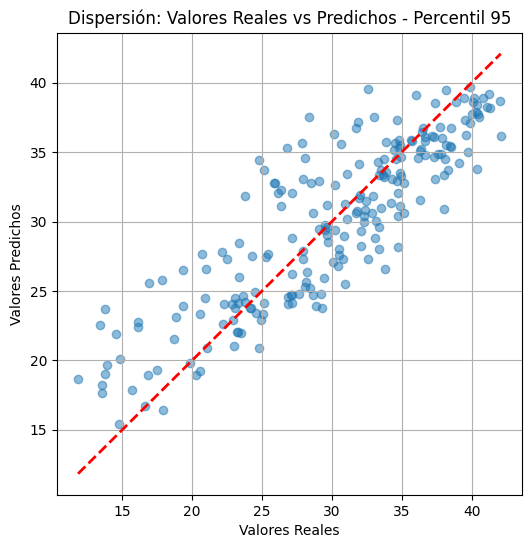

R^2: 0.735885448205466


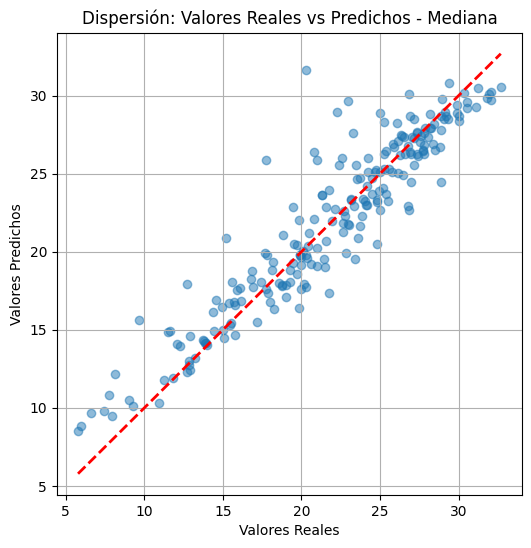

R^2: 0.8716469310097383


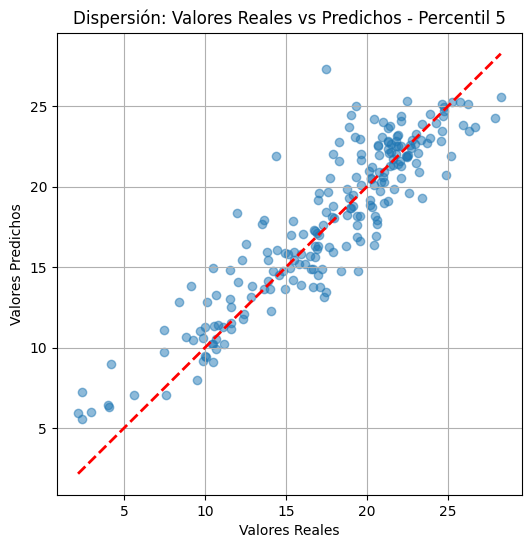

R^2: 0.8212007838060524


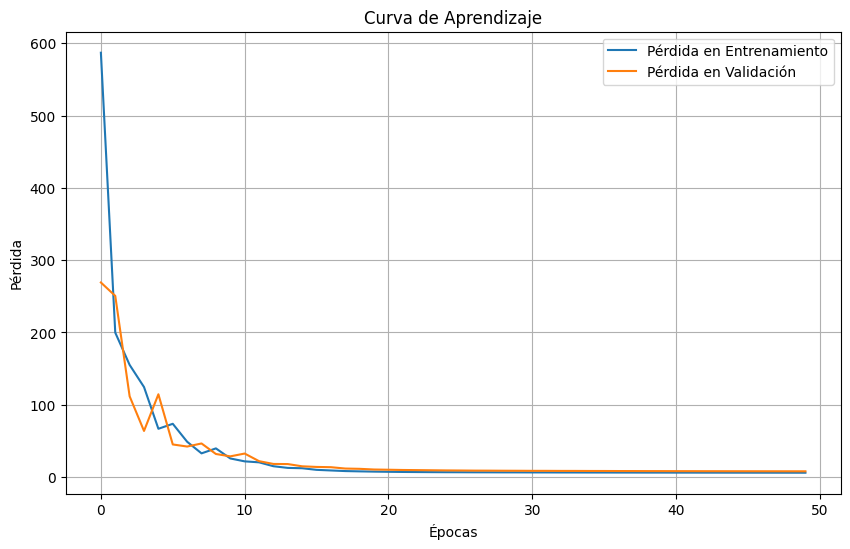

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Predicciones del modelo final en el conjunto de validación
y_pred = modelo_final.predict(X_validacion)

# Crear gráficos de dispersión para cada percentil
percentiles = ['Percentil 95', 'Mediana', 'Percentil 5']

for i, percentil in enumerate(percentiles):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_validacion[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_validacion[:, i].min(), y_validacion[:, i].max()], [y_validacion[:, i].min(), y_validacion[:, i].max()], 'r--', lw=2)
    plt.title(f'Dispersión: Valores Reales vs Predichos - {percentil}')
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Predichos')
    plt.grid(True)
    plt.show()
    # Calculate R^2
    r2 = r2_score(y_validacion[:, i], y_pred[:, i])
    print(f"R^2: {r2}")

# Curva de aprendizaje (pérdida)
plt.figure(figsize=(10, 6))
plt.plot(historial.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida en Validación')
plt.title('Curva de Aprendizaje')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

#Mejores valores de Optuna
optuna.visualization.plot_optimization_history(estudio)

In [37]:
#Importancia de los hiperparámetros
optuna.visualization.plot_param_importances(estudio)